# Cis-coaccessibility Networks (CCANs)

Looking at genes within CCANs computed by Cicero and their expression.

In [25]:
library(cicero)
library(Matrix)
library(ggplot2)
library(scales)
library(rtracklayer)
library(reshape2)
library(DESeq2)

In [2]:
gz = gzfile("./out/20200417_default_20200220_n74838/ccans.thresh0.3.tsv.gz")
ccans = read.table(gz)
head(ccans)

,V1,V2
,<fct>,<int>
1,chr10_100006055_100006360,2761
2,chr10_100006376_100006866,2761
3,chr10_100038048_100038259,2761
4,chr10_100038266_100038787,2761
5,chr10_100038800_100039001,2761
6,chr10_100044317_100044523,2761


In [15]:
pmat = readMM("../20200206_pmat_snapATAC/sessions/20200220_n74838/pmat.sparse.mm")
pmat = as(pmat, "dgCMatrix")
dim(pmat)

[1]  74838 467339

In [16]:
# Metadata file from previous run
# should contain, sample_barcode as rowname, sample, umap1, umap2, cluster
metaData = read.table("../20200206_pmat_snapATAC/sessions/20200220_n74838/metadata.tsv", header = T)
metaData$barcode = lapply(strsplit(rownames(metaData), '_'), "[[", 2)
metaData$cells = rownames(metaData) # for cicero
dim(metaData)
head(metaData, 5)

[1] 74838     6

,sample,umap.1,umap.2,cluster,barcode,cells
,<fct>,<dbl>,<dbl>,<int>,<list>,<chr>
D0_AAACAACGACGATTAC,D0,6.545686,-7.701751,2,AAACAACGACGATTAC,D0_AAACAACGACGATTAC
D0_AAACAACGACTCACGG,D0,5.180663,-7.633298,2,AAACAACGACTCACGG,D0_AAACAACGACTCACGG
D0_AAACAACGAGCGCACT,D0,6.080648,-8.114705,2,AAACAACGAGCGCACT,D0_AAACAACGAGCGCACT
D0_AAACAACGATGGAACG,D0,3.584474,-7.276754,1,AAACAACGATGGAACG,D0_AAACAACGATGGAACG
D0_AAACACGCTACGCCAC,D0,5.299551,-8.133782,2,AAACACGCTACGCCAC,D0_AAACACGCTACGCCAC


In [17]:
fine_clusters = read.table("../20200206_pmat_snapATAC/sessions/20200220_n74838/fine_clusters.tsv", header = T)
head(fine_clusters)

,sample_barcode,clusters
,<fct>,<int>
1,D0_AAACAACGACGATTAC,1
2,D0_AAACAACGACTCACGG,18
3,D0_AAACAACGAGCGCACT,14
4,D0_AAACAACGATGGAACG,18
5,D0_AAACACGCTACGCCAC,14
6,D0_AAACACGCTAGACTTC,14


In [18]:
all(fine_clusters$sample_barcode==rownames(metaData))

[1] TRUE

In [21]:
regions = read.table("../20200206_pmat_snapATAC/sessions/20200220_n74838/peaks.bed")
names(regions) = c("chr", "bp1", "bp2")
regions$site_name <- paste(regions$chr, regions$bp1, regions$bp2, sep="_")
row.names(regions) <- regions$site_name
dim(regions)
head(regions)

[1] 467339      4

,chr,bp1,bp2,site_name
,<fct>,<int>,<int>,<chr>
chr1_16146_16347,chr1,16146,16347,chr1_16146_16347
chr1_51458_51659,chr1,51458,51659,chr1_51458_51659
chr1_51688_52109,chr1,51688,52109,chr1_51688_52109
chr1_180685_181260,chr1,180685,181260,chr1_180685_181260
chr1_181267_181597,chr1,181267,181597,chr1_181267_181597
chr1_184384_184585,chr1,184384,184585,chr1_184384_184585


In [19]:
agg_matrix = sparseMatrix(i=fine_clusters$clusters,
                         j=seq(1,nrow(pmat)),
                         x=1L,
                         dims=c(length(table(fine_clusters$clusters)), nrow(pmat)))

In [22]:
cts = as.matrix(agg_matrix %*% pmat)
colnames(cts) = rownames(regions)
rownames(cts) = paste("cluster", seq(1,nrow(cts)), sep="_")
cts = t(cts)
head(cts)

,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,⋯,cluster_24,cluster_25,cluster_26,cluster_27,cluster_28,cluster_29,cluster_30,cluster_31,cluster_32,cluster_33
chr1_16146_16347,7,9,7,5,16,5,5,14,6,0,⋯,6,0,2,3,2,1,6,8,0,0
chr1_51458_51659,0,3,0,0,1,0,1,1,0,0,⋯,0,0,0,0,1,0,2,0,0,0
chr1_51688_52109,1,13,18,0,3,2,6,1,0,0,⋯,0,0,1,0,0,0,3,2,0,0
chr1_180685_181260,47,29,21,25,67,31,35,52,11,8,⋯,23,16,18,15,3,5,28,27,1,9
chr1_181267_181597,30,54,21,10,66,35,54,29,27,10,⋯,18,16,20,26,5,8,35,33,15,11
chr1_184384_184585,11,7,10,5,30,10,13,9,12,13,⋯,7,4,0,10,2,5,9,24,5,0


In [26]:
sum(rowSums(cts<10)==0)
norm_cts = t(t(cts)/estimateSizeFactorsForMatrix(cts[rowSums(cts<10)==0, ]))

[1] 44267

## Sanity Check

To see if metaData, matrix and regions are well-aligned

In [27]:
# region_gr = read.table("../../../resources/GSE36570/DBRs.hg38.bed")
region_gr = read.table("../20200307_fine_clustering/beds/20200330_gridmap_peakwidthnorm_n20/idx5.bed")
colnames(region_gr) = c("chr", "start", "end")
region_gr = makeGRangesFromDataFrame(region_gr)

In [30]:
tmp_regions = regions[,c("chr", "bp1", "bp2")]
colnames(tmp_regions) = c("chr", "start", "end")
norm_reads_in_region = colSums(norm_cts[unique(queryHits(findOverlaps(GRanges(tmp_regions), region_gr))),])

In [31]:
max(norm_reads_in_region)
median(norm_reads_in_region)
min(norm_reads_in_region)

[1] 1687665

[1] 55728.32

[1] 24305.47

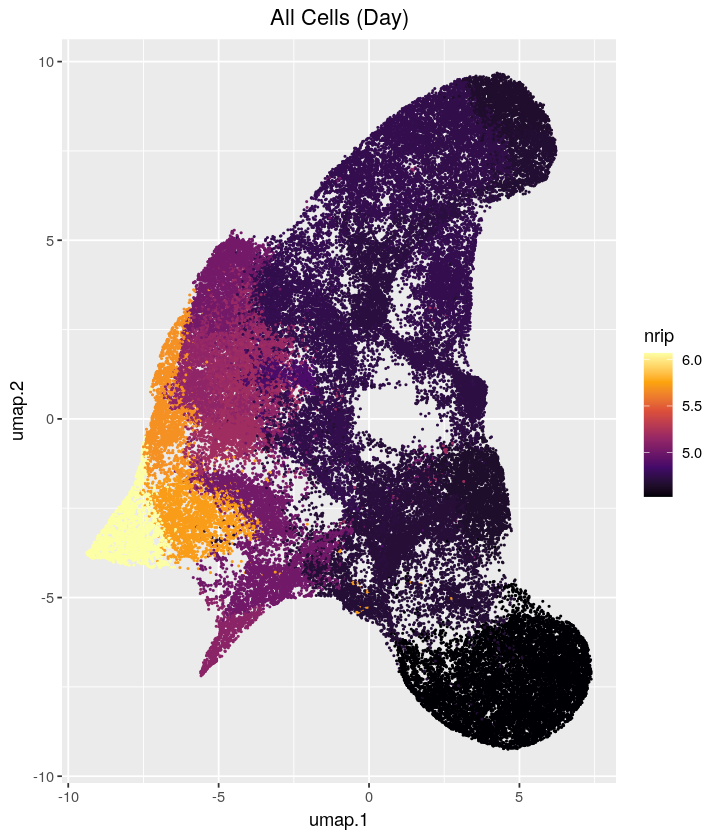

In [42]:
options(repr.plot.width = 6, repr.plot.height = 7)

df = data.frame(metaData, nrip=log10(norm_reads_in_region[fine_clusters$clusters]))
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
geom_point(size=0.2, alpha=1, aes(x=umap.1 , y=umap.2, col=nrip)) +
scale_color_viridis_c(limits=c(quantile(log10(norm_reads_in_region), 0.1), 
                               quantile(log10(norm_reads_in_region), 0.99)), 
                      oob=squish, option = "B") +
ggtitle("All Cells (Day)") + 
theme(plot.title = element_text(hjust = 0.5))
# guides(colour = guide_legend(override.aes = list(shape=16, alpha=1, size=4))) 

## Prepare Promoters

In [3]:
gencode.basic.hg38 = import.gff(gzfile("../../../resources/GENCODE/gencode.v33.chr_patch_hapl_scaff.basic.annotation.gtf.gz"))
gencode.basic.hg38 = keepStandardChromosomes(gencode.basic.hg38, pruning.mode = "coarse")
gencode.basic.tx.hg38 = subset(subset(gencode.basic.hg38, gene_type=="protein_coding"), type=="transcript")
head(gencode.basic.tx.hg38, 3)
length(gencode.basic.tx.hg38)

Warning message in readGFF(filepath, version = version, filter = filter):
"connection is not positioned at the start of the file, rewinding it"


GRanges object with 3 ranges and 21 metadata columns:
      seqnames        ranges strand |   source       type     score     phase
         <Rle>     <IRanges>  <Rle> | <factor>   <factor> <numeric> <integer>
  [1]     chr1   65419-71585      + |   HAVANA transcript      <NA>      <NA>
  [2]     chr1   69055-70108      + |  ENSEMBL transcript      <NA>      <NA>
  [3]     chr1 450703-451697      - |   HAVANA transcript      <NA>      <NA>
                gene_id      gene_type   gene_name       level     hgnc_id
            <character>    <character> <character> <character> <character>
  [1] ENSG00000186092.6 protein_coding       OR4F5           2  HGNC:14825
  [2] ENSG00000186092.6 protein_coding       OR4F5           3  HGNC:14825
  [3] ENSG00000284733.1 protein_coding      OR4F29           2  HGNC:31275
               havana_gene     transcript_id transcript_type transcript_name
               <character>       <character>     <character>     <character>
  [1] OTTHUMG00000001094.4 

[1] 58073

In [4]:
tss.hg38 = unique(resize(gencode.basic.tx.hg38, width=1, fix='start'))

In [5]:
# for downstream analyses, allow co-accessibility to tss proximal enhancers
prom.hg38 = promoters(tss.hg38, upstream = 2500, downstream = 2500)

## Load mRNA data

In [6]:
# load bulk RNA-seq data
fpkm = read.table("/users/surag/kundajelab/scATAC-reprog/resources/GSE62777/RNAseq.FPKM.tsv", sep='\t', header=T)
fpkm$gene_id = NULL
fpkm$locus=NULL
tpm = fpkm
tpm[,2:ncol(tpm)] = 1e6*t(t(tpm[,2:ncol(tpm)])/colSums(tpm[,2:ncol(tpm)]))

# removing genes with dup names
tpm = tpm[!duplicated(tpm$gene_short_name),]
rownames(tpm) = tpm$gene_short_name
tpm$gene_short_name = NULL

tpm["GAPDH",]

,hiF.T_P14,X2dd_DOX_plus,X5dd_DOX_plus,X8dd_DOX_plus,X10dd_DOX_plus_SSEA3_pos,X14dd_DOX_plus_SSEA3_pos,X20dd_DOX_plus_TRA_plus,X24dd_TRA_pos_DOX_plus,X24dd_TRA_pos_DOX_minus,hIPSC.T_P10
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GAPDH,7803.64,4963.505,3908.693,3839.776,3795.548,3364.503,3032.412,3790.955,5598.224,4731.256


## Accessibility in CCANs

In [7]:
peaks = sub("_", "-", sub("_", ":", ccans$V1))

In [199]:
quantile(table(ccans$V2), c(0, 0.25, 0.5, 0.75, 0.9, 0.98, 1))

  0%  25%  50%  75%  90%  98% 100% 
   3    3    3    6   23   76  377 

In [299]:
head(rev(sort(table(ccans$V2))), 10)


15249 30977 33160 23425 25213 31536 53526  2104   138 34019 
  377   366   278   272   270   257   253   251   247   245 

In [390]:
sum(table(ccans$V2)>50)

[1] 508

In [461]:
NID = 51659
NID = as.integer(sample(names(table(ccans$V2)[table(ccans$V2)>50]), 1))
NID

[1] 15608

In [462]:
sum(ccans$V2==NID)

[1] 53

In [463]:
norm_reads_in_ccan = colSums(norm_cts[rownames(norm_cts) %in% as.character(ccans$V1[ccans$V2==NID]),])
max(norm_reads_in_ccan)
median(norm_reads_in_ccan)
min(norm_reads_in_ccan)

[1] 7045.834

[1] 3040.746

[1] 789.6726

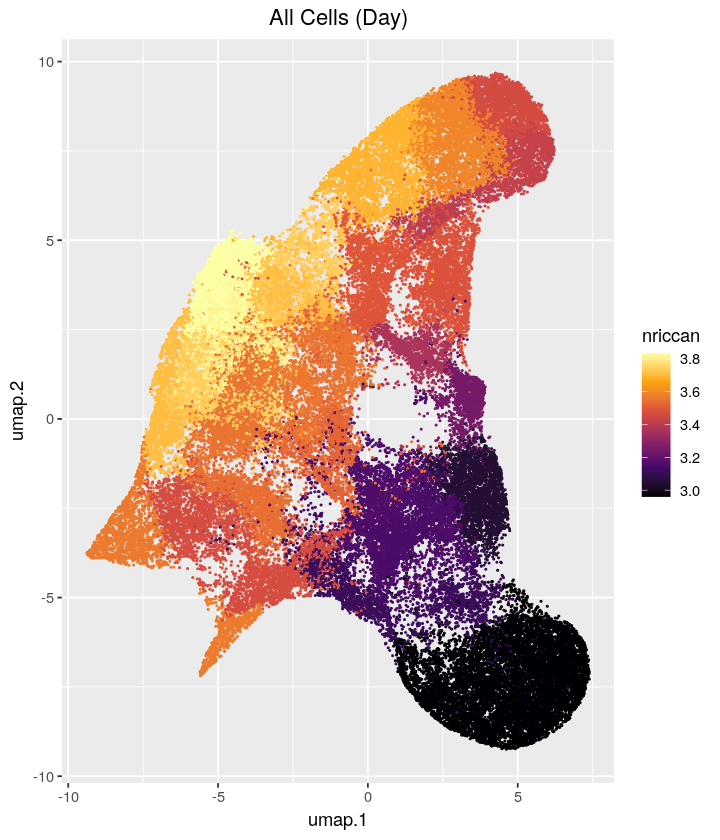

In [464]:
options(repr.plot.width = 6, repr.plot.height = 7)

df = data.frame(metaData, nriccan=log10(1+norm_reads_in_ccan[fine_clusters$clusters]))
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
geom_point(size=0.2, alpha=1, aes(x=umap.1 , y=umap.2, col=nriccan)) +
scale_color_viridis_c(limits=c(quantile(log10(norm_reads_in_ccan+1), 0.1), 
                               quantile(log10(norm_reads_in_ccan+1), 0.99)), 
                      oob=squish, option = "B") +
ggtitle("All Cells (Day)") + 
theme(plot.title = element_text(hjust = 0.5))
# guides(colour = guide_legend(override.aes = list(shape=16, alpha=1, size=4))) 

## mRNA analysis for Genes in CCAN

From Cachiarelli et al 2015

In [465]:
genes_in_ccan = unique(prom.hg38[queryHits(findOverlaps(prom.hg38, GRanges(peaks[ccans$V2==NID])))]$gene_name)
length(genes_in_ccan)

[1] 4

In [466]:
genes_in_ccan

[1] "SLC47A1" "SLC47A2" "AKAP10"  "SPECC1"

In [467]:
gene_set_to_plot = genes_in_ccan

In [468]:
colMedians(as.matrix(log2(1+tpm)[rownames(tpm) %in% gene_set_to_plot, ]))

[1] 1.429183 2.040222 2.233507 3.093887 3.146314 3.671943 3.821130 3.580423
 [9] 3.156910 2.340035

[1] 4

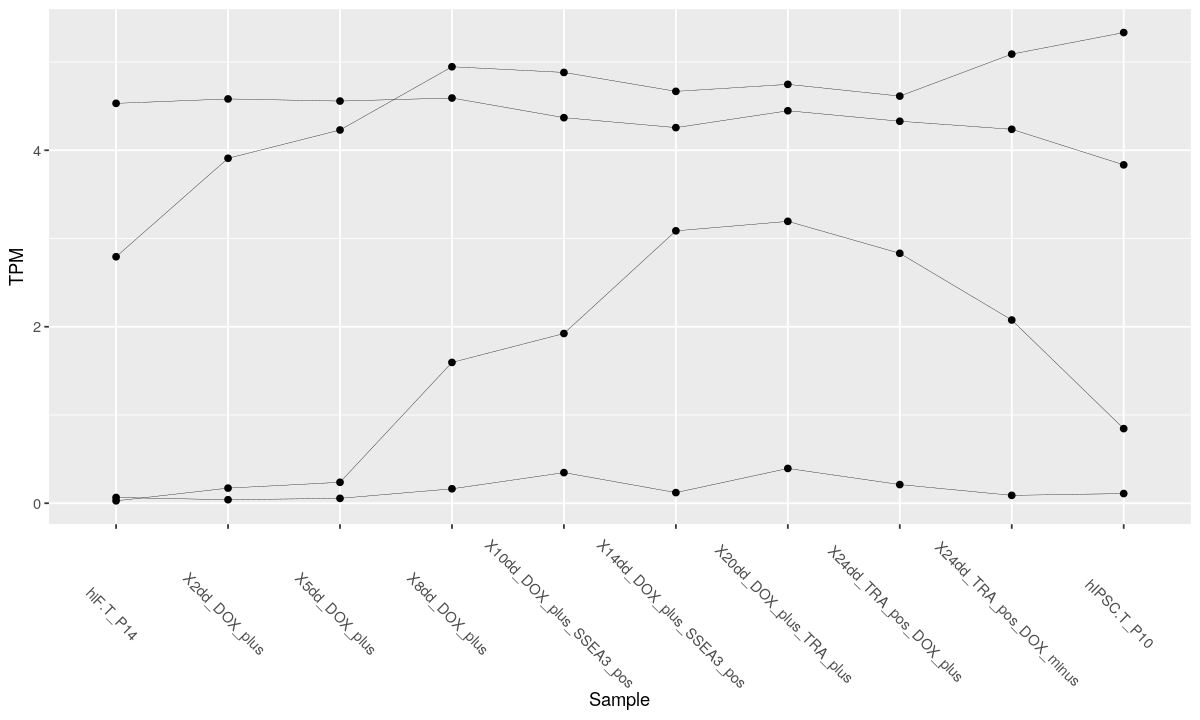

In [469]:
options(repr.plot.width = 10, repr.plot.height = 6)

sum(gene_set_to_plot %in% rownames(tpm))

ggplot(melt(as.matrix(log2(1+tpm)[rownames(tpm) %in% gene_set_to_plot, ])), aes(x=Var2, y=value)) +
# ggplot(melt(t(scale(t(log2(1+tpm)[rownames(tpm) %in% gene_set_to_plot, ])))), aes(x=Var2, y=value)) +
# stat_boxplot() +
geom_line(aes(group=Var1),size=0.1) + geom_point() +
theme(axis.text.x = element_text(angle = -45)) +
ylab("TPM") + xlab("Sample")
# geom_boxplot(outlier.shape = NA) + geom_jitter(width = 0.2)
# coord_cartesian(ylim=c(0,8)) 

In [470]:
log2(1+tpm)[rownames(tpm) %in% gene_set_to_plot, ]

,hiF.T_P14,X2dd_DOX_plus,X5dd_DOX_plus,X8dd_DOX_plus,X10dd_DOX_plus_SSEA3_pos,X14dd_DOX_plus_SSEA3_pos,X20dd_DOX_plus_TRA_plus,X24dd_TRA_pos_DOX_plus,X24dd_TRA_pos_DOX_minus,hIPSC.T_P10
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AKAP10,4.53185635,4.58176613,4.55764517,4.592053,4.3692479,4.2568529,4.447822,4.3287196,4.23756362,3.8346005
SPECC1,2.79336326,3.90925613,4.22985209,4.946353,4.8819976,4.6675988,4.746942,4.6137087,5.08986907,5.3341211
SLC47A1,0.02723966,0.17118775,0.23716115,1.595722,1.9233797,3.0870335,3.194437,2.8321272,2.07625581,0.8454703
SLC47A2,0.06500193,0.03962507,0.05530616,0.163546,0.3468916,0.1203067,0.394050,0.2111829,0.08917771,0.1096278
